Exploring several features

In [245]:
from abc import ABC, abstractmethod
import re
from sacremoses import MosesTokenizer
import Levenshtein
import spacy
import nltk
import pickle
import urllib
import os
import tarfile
import zipfile
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import numpy as np
# import paths
from string import punctuation
import matplotlib.pyplot as plt
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk import word_tokenize
RESOURCES_DIR = Path('../resources')
DATASETS_PATH = RESOURCES_DIR / "datasets"
WORD_EMBEDDINGS_NAME = "glove.42B.300d"
DUMPS_DIR = RESOURCES_DIR / "DUMPS"
import requests
import gensim

stopwords = set(stopwords.words("dutch"))


In [ ]:
# alternatives for Glove in Dutch: 

# https://fasttext.cc/docs/en/support.html#building-fasttext-python-module  voc size unknown, dims 300 installation failed because of wheel.
# http://vectors.nlpl.eu/repository/#  voc size 2610658, dims 100
# coosto https://github.com/coosto/dutch-word-embeddings  vocabulary 250479 dims 300 media data! 

In [246]:
def ControlDivisionByZero(numerator, denominator):
    return numerator / denominator if denominator != 0 else 0


class FeatureAbstract(ABC):

    @abstractmethod
    def get_ratio(self, kwargs):
        pass

    @abstractmethod
    def calculate_ratio(self, simple_text, original_text):
        pass


class Feature(FeatureAbstract):

    def __init__(self, split, target_ratio):
        self.split = split
        self.target_ratio = target_ratio

    def get_ratio(self, kwargs):
        if not 'original_text_preprocessed' in kwargs:
            kwargs['original_text_preprocessed'] = ""

        if self.split == "train":
            simple_text = kwargs.get('simple_text')
            original_text = kwargs.get('original_text')
            result_ratio = self.calculate_ratio(simple_text, original_text)

        elif self.split == "valid" or self.split == "test":
            result_ratio = self.target_ratio
        else:
            raise ValueError("stage value not supported")
        kwargs['original_text_preprocessed'] += f'{self.name}_{result_ratio} '
        return kwargs

    @property
    def name(self):
        class_name = self.__class__.__name__
        name = ""
        for word in re.findall('[A-Z][^A-Z]*', class_name):
            if word: name += word[0]
        if not name: name = class_name
        return name


class WordLengthRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)
        if stage == "train":
            # THIS IS A WORD TOKENIZER, we need one for dutch
            # nl_core_news_sm spacy  spacy.nl_core_news_sm 
            # nltk.word_tokenize
            self.tokenizer =  MosesTokenizer(lang='nl') #  nltk.word_tokenize(language='dutch')  # Moses Tokenizer for Dutch language

    def calculate_ratio(self, simple_text, original_text):
        return round(ControlDivisionByZero(
            len(self.tokenizer.tokenize(simple_text)),
            len(self.tokenizer.tokenize(original_text))), 2)


class CharLengthRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)

    def calculate_ratio(self, simple_text, original_text):
        return round(ControlDivisionByZero(len(simple_text),
            len(original_text)), 2)


class LevenshteinRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)

    def calculate_ratio(self, simple_text, original_text):
        simple_text = word_tokenize(simple_text,language='dutch')
        original_text = word_tokenize(original_text,language='dutch')
        return round(Levenshtein.seqratio(original_text,
                                       simple_text), 2)


class DependencyTreeDepthRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)
        if stage == "train":
            self.nlp = self.get_spacy_model()

    def get_spacy_model(self):

        model = 'nl_core_news_sm'  # from spacy, Dutch pipeline optimized for CPU. Components: tok2vec, morphologizer, tagger, parser, lemmatizer (trainable_lemmatizer), senter, ner.
        if not spacy.util.is_package(model):
            spacy.cli.download(model)
            spacy.cli.link(model, model, force=True, model_path=spacy.util.get_package_path(model))
        return spacy.load(model)

    def calculate_ratio(self, simple_text, original_text):

        result_ratio = round(ControlDivisionByZero(
            self.get_dependency_tree_depth(simple_text),
            self.get_dependency_tree_depth(original_text)), 2)

        return result_ratio

    def get_dependency_tree_depth(self, sentence):

        def get_subtree_depth(node):
            if len(list(node.children)) == 0:
                return 0
            return 1 + max([get_subtree_depth(child) for child in node.children])

        tree_depths = [get_subtree_depth(spacy_sentence.root) for spacy_sentence in self.nlp(sentence).sents]
        if len(tree_depths) == 0:
            return 0
        return max(tree_depths)


class WordRankRatio(Feature):
    # single underscore = internally

    def __init__(self, stage, target_ratio): # constructor of the class 
        super().__init__(stage, target_ratio)
        if stage == "train":
            self.tokenizer = MosesTokenizer(lang='nl')
            self.word2rank = self._get_word2rank()
            self.length_rank = len(self.word2rank)

    def calculate_ratio(self, simple_text, original_text):

        result_ratio = round(min(ControlDivisionByZero(self.get_lexical_complexity_score(simple_text),
                                                       self.get_lexical_complexity_score(original_text)),
                                 2), 2)

        return result_ratio

    def get_lexical_complexity_score(self, sentence, quantile_value=0.75):

        words = self.tokenizer.tokenize(self._remove_stopwords(self._remove_punctuation(sentence)))
        words = [word for word in words if word in self.word2rank]
        if len(words) == 0:
            return np.log(1 + self.length_rank)
        return np.quantile([self._get_rank(word) for word in words], quantile_value)

    def _remove_punctuation(self, text):
        return ' '.join([word for word in self.tokenizer.tokenize(text) if not self._is_punctuation(word)])

    def _remove_stopwords(self, text):
        return ' '.join([w for w in self.tokenizer.tokenize(text) if w.lower() not in stopwords])

    def _is_punctuation(self, word):
        return ''.join([char for char in word if char not in punctuation]) == ''

    def _get_rank(self, word):
        rank = self.word2rank.get(word, self.length_rank)
        return np.log(1 + rank)

    def _get_word2rank(self, vocab_size=np.inf):
        
        
        model_filepath = DUMPS_DIR / f"{WORD_EMBEDDINGS_NAME}.pk"
        
        
        if model_filepath.exists():
            with open(model_filepath, 'rb') as f:
                model = pickle.load(f)
            return model
        
        
        else:
            print("Downloading glove.42B.300d ...") # pretrained vectors
            self._download_glove(model_name='glove.42B.300d', dest_dir=str(DUMPS_DIR))
            print("Preprocessing word2rank...")
            DUMPS_DIR.mkdir(parents=True, exist_ok=True)
            WORD_EMBEDDINGS_PATH = DUMPS_DIR / f'{WORD_EMBEDDINGS_NAME}.txt'
            lines_generator = self._yield_lines(WORD_EMBEDDINGS_PATH)
            
            
        # # def _download_word_embeddings():
        #     WE_FILE = 'coosto.bin'
        # wordembeddings_url = 'https://github.com/coosto/dutch-word-embeddings/releases/download/v1.0/model.bin'
        # r = requests.get(wordembeddings_url)
        # if r.status_code == 200:
        #     with open(WE_FILE, 'wb') as wordembeddings_file:
        #         wordembeddings_file.write(
        #             r.content
        #         )
            
        # https://github.com/tommasoc80/DALC/blob/2085fddf0fbac065c493b97079ae4ec27ddc7e00/v2.0/models/.ipynb_checkpoints/DALC_BiLSTM_offensive_binary-checkpoint.ipynb
        
        
            word2rank = {}
            # next(lines_generator)
            for i, line in enumerate(lines_generator):
                if i >= vocab_size: break
                word = line.split(' ')[0]
                word2rank[word] = i
                print('ranked word?', word2rank[word])

            pickle.dump(word2rank, open(model_filepath, 'wb'))
            txt_file = DUMPS_DIR / f'{WORD_EMBEDDINGS_NAME}.txt'
            zip_file = DUMPS_DIR / f'{WORD_EMBEDDINGS_NAME}.zip'
            if txt_file.exists(): txt_file.unlink()
            if zip_file.exists(): zip_file.unlink()
            return word2rank
    

                
                # store as TXT? 
# download_word_embeddings()
    
    # def load_word_embeddings():
        return gensim.models.KeyedVectors.load_word2vec_format(WE_FILE, binary=True)

#  word_model = load_word_embeddings()
    def _vectorize_data(data, wm):
        # turn the tokens into coosto vocab indices
        # these will be converted to embeddings in the Embedding layer
        vocab = wm.vocab
        keys = list(vocab.keys())
        final = []
        for tweet in data:
            final.append([keys.index(word) for word in tweet if vocab.get(word, None) is not None])
        return final

    def _download_glove(self, model_name, dest_dir): # pretrained rankings
        url = ''
        if model_name == 'glove.6B':
            url = 'http://nlp.stanford.edu/data/glove.6B.zip'
        elif model_name == 'glove.42B.300d':
            url = 'http://nlp.stanford.edu/data/glove.42B.300d.zip'
        elif model_name == 'glove.840B.300d':
            url = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
        elif model_name == 'glove.twitter.27B':
            url = 'http://nlp.stanford.edu/data/glove.twitter.27B.zip',
        else:
            possible_values = ['glove.6B', 'glove.42B.300d', 'glove.840B.300d', 'glove.twitter.27B']
            raise ValueError('Unknown model_name. Possible values are {}'.format(possible_values))
        file_path = self._download_url(url, dest_dir)
        out_filepath = Path(file_path)
        out_filepath = out_filepath.parent / f'{out_filepath.stem}.txt'
        # print(out_filepath, out_filepath.exists())
        if not out_filepath.exists():
            print("Extracting: ", Path(file_path).name)
            self._unzip(file_path, dest_dir)

    def _yield_lines(self, filepath):
        filepath = Path(filepath)
        with filepath.open('r', encoding="latin-1") as f:
            for line in f:
                yield line.rstrip()

    def _download_url(self, url, output_path):
        name = url.split('/')[-1]
        file_path = f'{output_path}/{name}'
        if not Path(file_path).exists():
            with tqdm(unit='B', unit_scale=True, leave=True, miniters=1,
                      desc=name) as t:  # all optional kwargs
                urllib.request.urlretrieve(url, filename=file_path, reporthook=self._download_report_hook(t), data=None)
        return file_path

    def _unzip(self, file_path, dest_dir=None):
        if dest_dir is None:
            dest_dir = os.path.dirname(file_path)
        if file_path.endswith('.zip'):
            with zipfile.ZipFile(file_path, "r") as zip_ref:
                zip_ref.extractall(dest_dir)
        elif file_path.endswith("tar.gz") or file_path.endswith("tgz"):
            tar = tarfile.open(file_path, "r:gz")
            tar.extractall(dest_dir)
            tar.close()
        elif file_path.endswith("tar"):
            tar = tarfile.open(file_path, "r:")
            tar.extractall(dest_dir)
            tar.close()

    def _download_report_hook(self, t):
        last_b = [0]

        def inner(b=1, bsize=1, tsize=None):
            if tsize is not None:
                t.total = tsize
            t.update((b - last_b[0]) * bsize)
            last_b[0] = b

        return inner

In [247]:
sentences_pair = {"simple_text": "Dit is de complexe versie", "original_text": "Dit is de vereenvoudigte versie."}

In [ ]:
word_rank = WordRankRatio("train", 0.8)
sentences_pair = word_rank.get_ratio(sentences_pair)
sentences_pair

In [248]:
char = CharLengthRatio("train", 0.8)
sentences_pair = char.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'Dit is de complexe versie',
 'original_text': 'Dit is de vereenvoudigte versie.',
 'original_text_preprocessed': 'CLR_0.78 '}

In [249]:
word_length = WordLengthRatio("train", 0.8)
sentences_pair = word_length.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'Dit is de complexe versie',
 'original_text': 'Dit is de vereenvoudigte versie.',
 'original_text_preprocessed': 'CLR_0.78 WLR_0.83 '}

In [250]:
levenshtein = LevenshteinRatio("train", 0.8)
sentences_pair = levenshtein.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'Dit is de complexe versie',
 'original_text': 'Dit is de vereenvoudigte versie.',
 'original_text_preprocessed': 'CLR_0.78 WLR_0.83 LR_0.63 '}

In [251]:
dependency = DependencyTreeDepthRatio("train", 0.8)
sentences_pair = dependency.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'Dit is de complexe versie',
 'original_text': 'Dit is de vereenvoudigte versie.',
 'original_text_preprocessed': 'CLR_0.78 WLR_0.83 LR_0.63 DTDR_1.0 '}

In [252]:
word_rank = WordRankRatio("train", 0.8)
sentences_pair = word_rank.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'Dit is de complexe versie',
 'original_text': 'Dit is de vereenvoudigte versie.',
 'original_text_preprocessed': 'CLR_0.78 WLR_0.83 LR_0.63 DTDR_1.0 WRR_1.02 '}

Exploring features values from simpleText shared task

In [253]:
# SIMPLETEXT_DATASET_PATH = DATASETS_PATH / "simpleText"

In [254]:
WIKILARGE_DATASET_PATH = DATASETS_PATH / "wikilarge"

In [255]:
complex_text = pd.read_csv(WIKILARGE_DATASET_PATH / "wikilarge.train.orig.txt", header=None, sep="\t", names=["original_text"])
simple_text = pd.read_csv(WIKILARGE_DATASET_PATH / "wikilarge.train.simp.txt", header=None, sep="\t",names=["simple_text"])

In [256]:
# complex_text = pd.read_csv(SIMPLETEXT_DATASET_PATH / "simpleText.train.complex.txt", header=None, sep="\t", names=["original_text"])
# simple_text = pd.read_csv(SIMPLETEXT_DATASET_PATH / "simpleText.train.simple.txt", header=None, sep="\t",names=["simple_text"])

In [257]:
sentences_pairs = pd.concat([complex_text, simple_text], axis=1)
sentences_pairs = sentences_pairs[1:60]

In [258]:
results = []
for i,row in sentences_pairs.iterrows():
    sentences_pair = dict(original_text=row['original_text'], simple_text=row['simple_text'])
    sentences_pair = char.get_ratio(sentences_pair)
    sentences_pair = word_length.get_ratio(sentences_pair)
    sentences_pair = levenshtein.get_ratio(sentences_pair)
    sentences_pair = dependency.get_ratio(sentences_pair)
    sentences_pair = word_rank.get_ratio(sentences_pair)
    features = sentences_pair["original_text_preprocessed"].strip().split(" ")
    instance = dict(feature.split("_") for feature in features)
    results.append(instance)

In [259]:
len(results)
results_df = pd.DataFrame(results).astype('float')

In [ ]:
_get_word2rank

In [260]:
results_df

,CLR,WLR,LR,DTDR,WRR
0,0.73,0.79,0.83,1.00,1.03
1,0.98,1.00,0.45,0.67,1.09
2,1.02,1.03,0.98,1.00,0.98
3,1.01,0.84,0.28,0.75,1.08
4,0.98,0.95,0.89,1.00,1.03
5,1.00,1.00,1.00,1.00,1.00
6,0.82,0.84,0.73,0.75,1.01
7,0.33,0.33,0.27,0.50,0.94
8,1.35,1.86,0.57,1.50,0.66
9,1.00,1.00,1.00,1.00,1.00


In [261]:
results_df

,CLR,WLR,LR,DTDR,WRR
0,0.73,0.79,0.83,1.00,1.03
1,0.98,1.00,0.45,0.67,1.09
2,1.02,1.03,0.98,1.00,0.98
3,1.01,0.84,0.28,0.75,1.08
4,0.98,0.95,0.89,1.00,1.03
5,1.00,1.00,1.00,1.00,1.00
6,0.82,0.84,0.73,0.75,1.01
7,0.33,0.33,0.27,0.50,0.94
8,1.35,1.86,0.57,1.50,0.66
9,1.00,1.00,1.00,1.00,1.00


Summary statistics

In [262]:
results_df.describe()

,CLR,WLR,LR,DTDR,WRR
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.738305,0.770847,0.580169,0.817797,0.994576
std,0.350945,0.373637,0.253183,0.325529,0.103179
min,0.010000,0.050000,0.020000,0.000000,0.620000
25%,0.425000,0.470000,0.430000,0.600000,0.965000
50%,0.810000,0.870000,0.570000,1.000000,1.000000
75%,0.995000,1.000000,0.795000,1.000000,1.035000
max,1.650000,1.940000,1.000000,1.500000,1.180000


In [263]:
results_df.describe()

,CLR,WLR,LR,DTDR,WRR
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.738305,0.770847,0.580169,0.817797,0.994576
std,0.350945,0.373637,0.253183,0.325529,0.103179
min,0.010000,0.050000,0.020000,0.000000,0.620000
25%,0.425000,0.470000,0.430000,0.600000,0.965000
50%,0.810000,0.870000,0.570000,1.000000,1.000000
75%,0.995000,1.000000,0.795000,1.000000,1.035000
max,1.650000,1.940000,1.000000,1.500000,1.180000


Character Length Ratio

C:\Users\Theresa\AppData\Local\Temp\ipykernel_15436\1850658161.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df["CLR"])


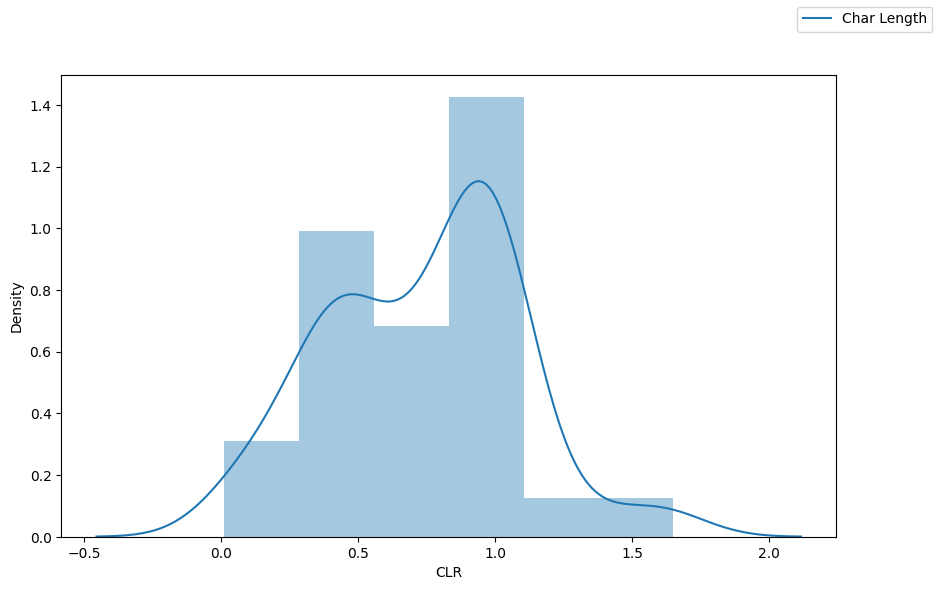

In [264]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results_df["CLR"])
fig.legend(labels=['Char Length'])
plt.show()

C:\Users\Theresa\AppData\Local\Temp\ipykernel_15436\349952001.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df["WLR"],label="Word Length")


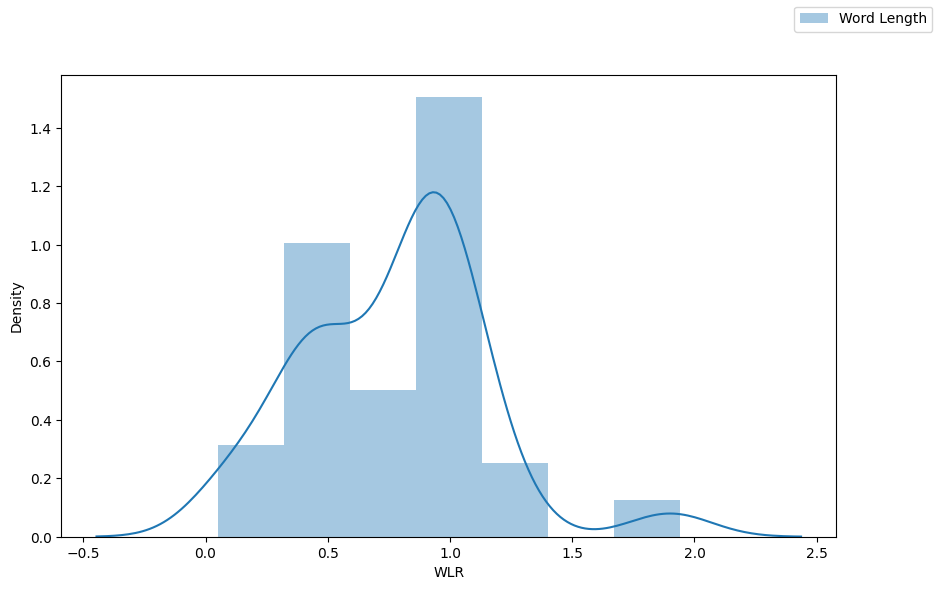

In [265]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results_df["WLR"],label="Word Length")
fig.legend(labels=['Word Length'])
plt.show()

C:\Users\Theresa\AppData\Local\Temp\ipykernel_15436\719872432.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df["LR"])


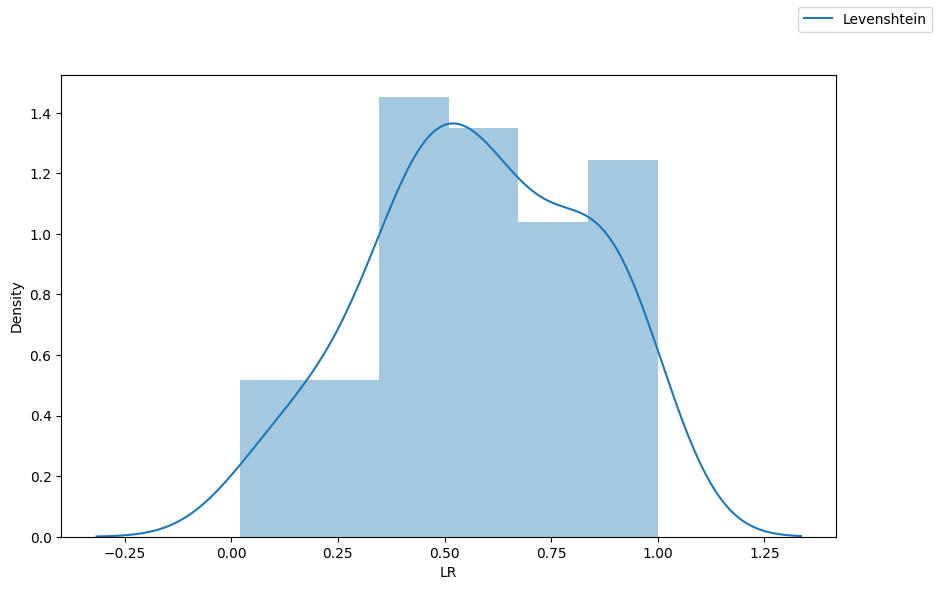

In [266]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results_df["LR"])
fig.legend(labels=['Levenshtein'])
plt.show()

C:\Users\Theresa\AppData\Local\Temp\ipykernel_15436\719872432.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df["LR"])


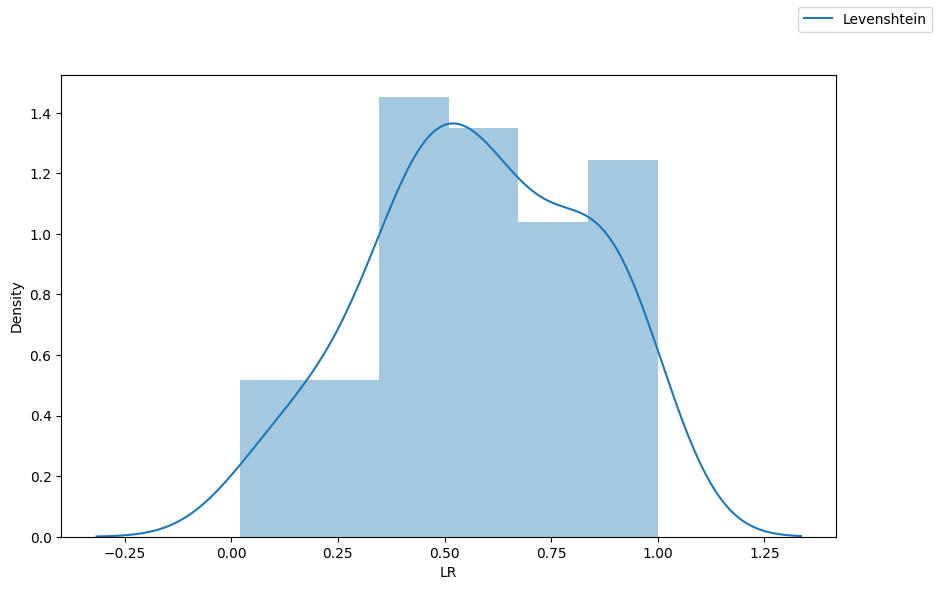

In [267]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results_df["LR"])
fig.legend(labels=['Levenshtein'])
plt.show()

C:\Users\Theresa\AppData\Local\Temp\ipykernel_15436\3105498735.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df["DTDR"])


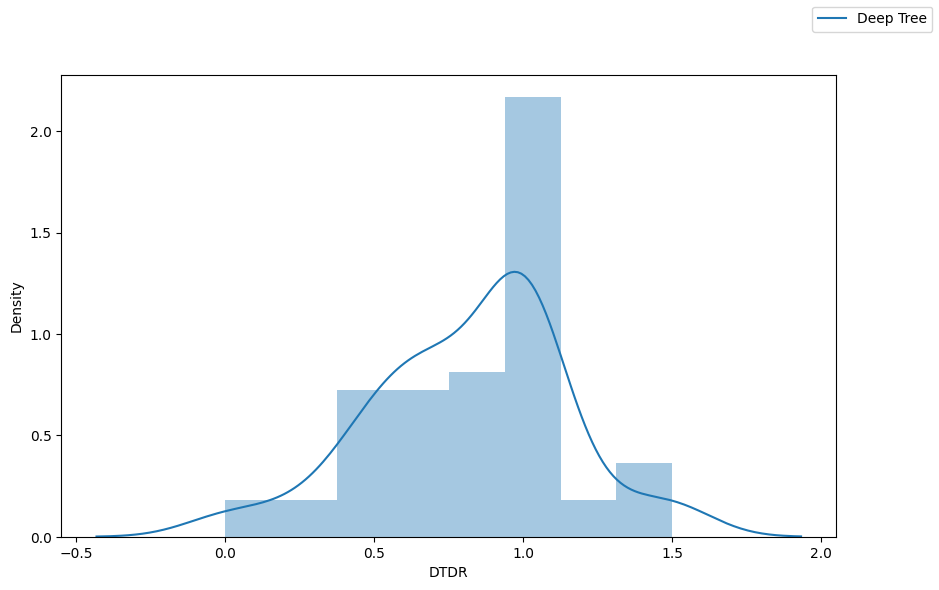

In [268]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results_df["DTDR"])
fig.legend(labels=['Deep Tree'])
plt.show()

C:\Users\Theresa\AppData\Local\Temp\ipykernel_15436\3939452026.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df["WRR"])


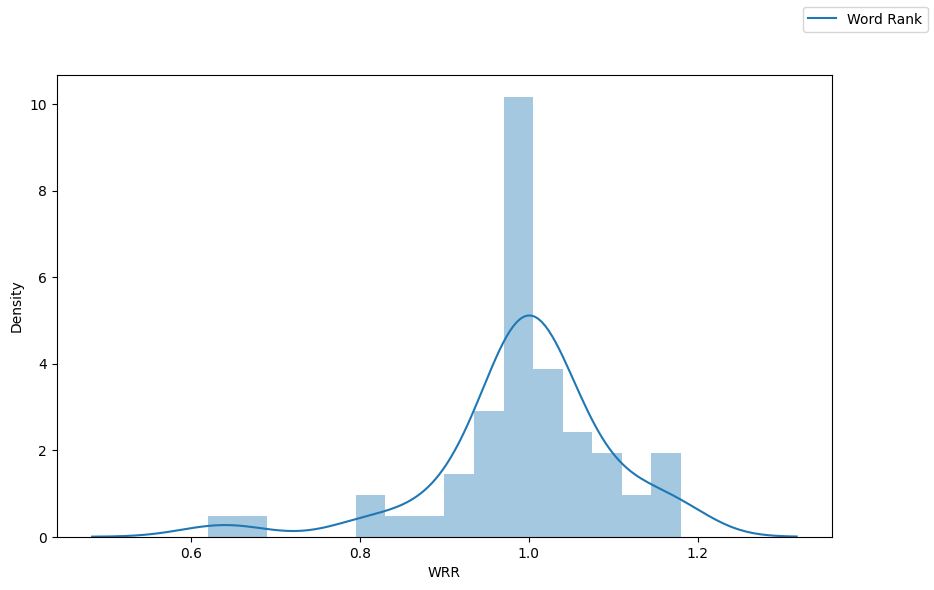

In [269]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results_df["WRR"])
fig.legend(labels=['Word Rank'])
plt.show()